In [41]:
from __future__ import print_function
import urllib
import bz2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.image as mpimg
import cv2
import plotly.graph_objs as go
import os
from utils.utils_IO import ordered_arr_3d_to_dict, refill_nan_array, arr_2d_to_list_of_dicts, read_image, make_image_array, revert_ordered_arr_2d_to_dict, save_object, write_video
from utils.utils_plotting import plot_image_labels, plot_3d_points, vector_plot, draw_circles, slope, drawLine, skew, plot_cams_and_points
from utils.utils_BA import fun, bundle_adjustment_sparsity, project
from anipose_BA import CameraGroup, Camera
from scipy.spatial.transform import Rotation as R
from pathlib import Path
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and process data

In [42]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def GetXYs(eid, video_type, trial_range):
    '''
    eid: session id, e.g. '3663d82b-f197-4e8b-b299-7b803a155b84'
    video_type: one of 'left', 'right', 'body'
    trial_range: first and last trial number of range to be shown, e.g. [5,7]
    '''
 
    one = ONE()
    dataset_types = ['camera.times',
                     'trials.intervals',
                     'camera.dlc']

    a = one.list(eid, 'dataset-types')

    assert all([i in a for i in dataset_types]
               ), 'For this eid, not all data available'

    D = one.load(eid, dataset_types=dataset_types, dclass_output=True)
    alf_path = Path(D.local_path[0]).parent.parent / 'alf'

    video_data = alf_path.parent / 'raw_video_data'     
    video_path = list(video_data.rglob('_iblrig_%sCamera.raw.*' % video_type))[0] 
    print(video_path) 

    # that gives cam time stamps and DLC output (change to alf_path eventually)
    
    cam1 = alf.io.load_object(video_path.parent, '_ibl_%sCamera' % video_type)     
    try:
        cam0 = alf.io.load_object(alf_path, '_ibl_%sCamera' % video_type)          
    except:
        cam0 = {}    
    cam = {**cam0,**cam1}

    # just to read in times for newer data (which has DLC results in pqt format
    #cam = alf.io.load_object(alf_path, '_ibl_%sCamera' % video_type)

    # pick trial range for which to display stuff
    trials = alf.io.load_object(alf_path, '_ibl_trials')
    num_trials = len(trials['intervals'])
    if trial_range[-1] > num_trials - 1:
        print('There are only %s trials' % num_trials)

    frame_start = find_nearest(cam['times'],
                               [trials['intervals'][trial_range[0]][0]])
    frame_stop = find_nearest(cam['times'],
                              [trials['intervals'][trial_range[-1]][1]])

    '''
    DLC related stuff
    '''
    Times = cam['times'][frame_start:frame_stop] 
    del cam['times']      

#    dlc_name = '_ibl_%sCamera.dlc.pqt' % video_type
#    dlc_path = alf_path / dlc_name
#    cam=pd.read_parquet(dlc_path)    


    points = np.unique(['_'.join(x.split('_')[:-1]) for x in cam.keys()])
    

    if video_type != 'body':
        d = list(points) 
        d.remove('tube_top')
        d.remove('tube_bottom')   
        points = np.array(d)


    # Set values to nan if likelyhood is too low # for pqt: .to_numpy()
    XYs = {}
    for point in points:
        x = np.ma.masked_where(
            cam[point + '_likelihood'] < 0.9, cam[point + '_x'])
        x = x.filled(np.nan)
        y = np.ma.masked_where(
            cam[point + '_likelihood'] < 0.9, cam[point + '_y'])
        y = y.filled(np.nan)
        XYs[point] = np.array(
            [x[frame_start:frame_stop], y[frame_start:frame_stop]])
            
    res_folder = '/home/mic/3D-Animal-Pose-master/IBL_example/%s_trials_%s_%s' %(eid, trial_range[0], trial_range[1])    
    
    Path(res_folder).mkdir(parents=True, exist_ok=True)    
            
    np.save('/home/mic/3D-Animal-Pose-master/IBL_example/%s_trials_%s_%s/XYs_%s.npy' %(eid, trial_range[0], trial_range[1], video_type), XYs)
    np.save('/home/mic/3D-Animal-Pose-master/IBL_example/%s_trials_%s_%s/times_%s.npy' %(eid, trial_range[0], trial_range[1], video_type), Times)
    #return XYs, Times


In [43]:
eid = 'cb2ad999-a6cb-42ff-bf71-1774c57e5308'
#eid = 'e5fae088-ed96-4d9b-82f9-dfd13c259d52'
trial_range = [5,7]
#trial_range = [10,13]
res_folder = '/Users/Sunsmeister/Desktop/Research/Brain/MultiView/3D-Animal-Pose/data/IBL_example/%s_trials_%s_%s' %(eid, trial_range[0], trial_range[1])

XYs_left = np.load(res_folder + '/XYs_left.npy', allow_pickle=True).flatten()[0]
XYs_right = np.load(res_folder + '/XYs_right.npy', allow_pickle=True).flatten()[0]

times_left = np.load(res_folder + '/times_left.npy')
times_right = np.load(res_folder + '/times_right.npy')

# get closest stamps or right cam (150 Hz) for each stamp of left (60 Hz)
idx_aligned = []
for t in times_left:
    idx_aligned.append(find_nearest(times_right, t))
    
# paw_l in video left = paw_r in video right
# Divide left coordinates by 2 to get them in half resolution like right cam; 
# reduce temporal resolution of right cam to that of left cam
num_analyzed_body_parts = 3  # both paws and nose

cam_right_paw1 = np.array([XYs_right['paw_r'][0][idx_aligned], XYs_right['paw_r'][1][idx_aligned]]) 
cam_left_paw1 = np.array([XYs_left['paw_l'][0]/2,XYs_left['paw_l'][1]/2]) 

cam_right_paw2 = np.array([XYs_right['paw_l'][0][idx_aligned], XYs_right['paw_l'][1][idx_aligned]]) 
cam_left_paw2 = np.array([XYs_left['paw_r'][0]/2,XYs_left['paw_r'][1]/2]) 

cam_right_nose = np.array([XYs_right['nose_tip'][0][idx_aligned], XYs_right['nose_tip'][1][idx_aligned]]) 
cam_left_nose = np.array([XYs_left['nose_tip'][0]/2,XYs_left['nose_tip'][1]/2]) 

# the format shall be such that points are concatenated, p1,p2,p3,p1,p2,p3, ... 
cam1 = np.zeros((len(idx_aligned) * num_analyzed_body_parts, 2)) 
cam1[0::3] = cam_right_paw1.T
cam1[1::3] = cam_right_paw2.T
cam1[2::3] = cam_right_nose.T

cam2 = np.zeros((len(idx_aligned) * num_analyzed_body_parts, 2)) 
cam2[0::3] = cam_left_paw1.T
cam2[1::3] = cam_left_paw2.T
cam2[2::3] = cam_left_nose.T

pts_array_2d_with_nans = np.array([cam1,cam2])

num_cameras, num_points_all, _ = pts_array_2d_with_nans.shape

# remove nans (any of the x_r,y_r, x_l, y_l) and keep clean_point_indices
non_nan_idc = ~np.isnan(pts_array_2d_with_nans).any(axis=2).any(axis=0)

info_dict = {}
info_dict['num_frames'] = len(times_left) 
info_dict['num_cameras'] = num_cameras
info_dict['num_analyzed_body_parts'] = num_analyzed_body_parts 
info_dict['num_points_all'] = num_points_all
info_dict['clean_point_indices'] = np.arange(num_points_all)[non_nan_idc]

print(info_dict)

pts_array_2d = pts_array_2d_with_nans[:,info_dict['clean_point_indices']]

IMG_WIDTH_1 = IMG_WIDTH_2 = 640
IMG_HEIGHT_1 = IMG_HEIGHT_2 = 512


{'num_frames': 784, 'num_cameras': 2, 'num_analyzed_body_parts': 3, 'num_points_all': 2352, 'clean_point_indices': array([   0,    1,    2, ..., 2349, 2350, 2351])}


In [44]:
import re
def sorted_nicely(l):
    """ Sort the given iterable in the way that humans expect."""
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [45]:
left_path = Path(f'/Users/Sunsmeister/Desktop/Research/Brain/MultiView/3D-Animal-Pose/data/IBL_example/{eid}_trials_{trial_range[0]}_{trial_range[1]}/imgs_left')
right_path = Path(f'/Users/Sunsmeister/Desktop/Research/Brain/MultiView/3D-Animal-Pose/data/IBL_example/{eid}_trials_{trial_range[0]}_{trial_range[1]}/imgs_right')
left_frames = sorted_nicely(os.listdir(left_path))
left_frames.append(left_frames[-1])
left_frames = [left_path / i for i in left_frames]
right_frames = sorted_nicely(os.listdir(right_path))
right_frames.append(right_frames[-1])
right_frames = [right_path / i for i in right_frames]

path_images = [left_frames, right_frames]

In [46]:
focal_length_mm = 16
sensor_size = 12.7

In [47]:
print(info_dict.keys())

dict_keys(['num_frames', 'num_cameras', 'num_analyzed_body_parts', 'num_points_all', 'clean_point_indices'])


# Requirements for Bundle Adjustment

`IMG_WIDTH_{1,2}`: (int) - Image width (pixels) for camera {1,2}

`IMG_HEIGHT_{1,2}`: (int) - Image height (pixels) for camera {1,2}

`pts_array_2d`: (np.array) - Array of shape (num_cameras, num_points, 2) containing set of 2d points for each camera. This should be after cleaning NaNs i.e. removing rows with NaNs

`info_dict`: Dictionary with keys {'num_frames', 'num_analyzed_body_parts', 'num_cameras', 'num_points_all', 'clean_point_indices'}

--> 'num_frames' is the number of frames in the video

--> 'num_analyzed_body_parts' is the number of body parts / joints being modeled (i.e. one per keypoint)

--> 'num_cameras' is the number of cameras. In our case, it is 2

--> 'num_points_all' is the original number of points (including NaNs)

--> 'clean_point_indices' is a list of indices (with length = num_points in `pts_array_2d`) pointing to the clean (non-NaN) entries in the original data

`path_images`: (list) - List of sublists. Each sublist (one per camera / view) contains absolute paths to image frames. 

`focal_length_mm`: (int) - Focal length of cameras in millimeters

`sensor_size` (int) - Sensor size of cameras in millimeters


In [48]:
import pickle
from pathlib import Path
def save_object(obj, filename, objects_dir='./rick_data_objects/'):
    with open(Path(objects_dir) / filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename, objects_dir='./rick_data_objects/'):
    obj = None
    with open(Path(objects_dir) / filename, 'rb') as input:
        obj = pickle.load(input)
    return obj

In [49]:
'''
save_object(info_dict, 'info_dict.pkl')
save_object(pts_array_2d, 'pts_array_2d.pkl')
offsets = [P_X_TOP, P_Y_1, P_X_1, P_Y_2]
save_object(offsets, 'offsets.pkl')
save_object(path_images, 'path_images.pkl')
'''

"\nsave_object(info_dict, 'info_dict.pkl')\nsave_object(pts_array_2d, 'pts_array_2d.pkl')\noffsets = [P_X_TOP, P_Y_1, P_X_1, P_Y_2]\nsave_object(offsets, 'offsets.pkl')\nsave_object(path_images, 'path_images.pkl')\n"

In [50]:
'''
#Load
info_dict = load_object('info_dict.pkl')
pts_array_2d = load_object('pts_array_2d.pkl')
offsets = load_object('offsets.pkl')
path_images = load_object('path_images.pkl')
[P_X_TOP, P_Y_1, P_X_1, P_Y_2] = offsets
IMG_WIDTH = P_X_TOP * 2
TOP_IMG_HEIGHT = P_Y_1 * 2
'''

"\n#Load\ninfo_dict = load_object('info_dict.pkl')\npts_array_2d = load_object('pts_array_2d.pkl')\noffsets = load_object('offsets.pkl')\npath_images = load_object('path_images.pkl')\n[P_X_TOP, P_Y_1, P_X_1, P_Y_2] = offsets\nIMG_WIDTH = P_X_TOP * 2\nTOP_IMG_HEIGHT = P_Y_1 * 2\n"

# Bundle Adjust

In [51]:
focal_length_1 = (16 * IMG_WIDTH_1) / 12.7
focal_length_2 = (16 * IMG_WIDTH_2) / 12.7

P_X_1 = IMG_WIDTH_1 // 2
P_X_2 = IMG_WIDTH_2 // 2
P_Y_1 = IMG_HEIGHT_1 // 2
P_Y_2 = IMG_HEIGHT_2 // 2

In [52]:
#--------CAMERA 1------------
#Initialize camera 1
camera_1 = Camera(rvec=[0,0,0], tvec=[0,0,0])
#Set offset
#camera_1.set_size((P_X_TOP, P_Y_1))

cam1_init_params = np.abs(np.random.rand(8))
#Set rotations [0:3] and translation [3:6] to 0
cam1_init_params[0:6] = 0
#Initialize focal length to image width
cam1_init_params[6] = focal_length_1
#Initialize distortion to 0
cam1_init_params[7] = 0.0 
#Set parameters
camera_1.set_params(cam1_init_params)
camera_1_mat = camera_1.get_camera_matrix()
camera_1_mat[0,2] = P_X_1
camera_1_mat[1,2] = P_Y_1
camera_1.set_camera_matrix(camera_1_mat)

#--------CAMERA 2------------
#Set rotation vector w.r.t. camera 1
# roration around y axis only, about 120 deg (2.0127 rad) from Guido's CAD
rvec2 = np.array([0, 2.0127, 0])

#Set translation vector w.r.t. camera 1, using CAD drawing [mm];
# cameras are 292.8 mm apart; 
#distance vector pointing from cam1 to the other cam: 
tvec2 = [-1.5664, 0, 2.4738]
#Initialize camera 2
camera_2 = Camera(rvec=rvec2, tvec=tvec2)
#Set offset 
camera_2.set_size((P_X_2, P_Y_2))

cam2_init_params = np.abs(np.random.rand(8))
cam2_init_params[0:3] = rvec2
cam2_init_params[3:6] = tvec2
cam2_init_params[6] =  focal_length_2
cam2_init_params[7] = 0.0
camera_2.set_params(cam2_init_params)
camera_2_mat = camera_2.get_camera_matrix()
camera_2_mat[0,2] = P_X_2
camera_2_mat[1,2] = P_Y_2
camera_2.set_camera_matrix(camera_2_mat)

#Group cameras
cam_group = CameraGroup(cameras=[camera_1, camera_2])

In [53]:
#Get error before Bundle Adjustment by triangulating using the initial parameters:
f0, points_3d_init = cam_group.get_initial_error(pts_array_2d)

In [54]:
print('----CAMERA 1-----')
print(camera_1.get_camera_matrix())
print('----CAMERA 2-----')
print(camera_2.get_camera_matrix())

----CAMERA 1-----
[[806.2992126   0.        320.       ]
 [  0.        806.2992126 256.       ]
 [  0.          0.          1.       ]]
----CAMERA 2-----
[[806.2992126   0.        320.       ]
 [  0.        806.2992126 256.       ]
 [  0.          0.          1.       ]]


In [55]:
coord_min = np.nanmin(points_3d_init)
coord_max = np.nanmax(points_3d_init)
scene_lims = [[coord_min, coord_max], [coord_min, coord_max], [coord_min, coord_max]]

In [56]:
fig = plot_cams_and_points(cam_group=cam_group, points_3d=points_3d_init, title="3D Points Initialized")

In [57]:
#Run Bundle Adjustment
res, points_3d = cam_group.bundle_adjust(pts_array_2d)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0919e+05                                    4.86e+06    
       1              4         2.6100e+05      4.82e+04       5.45e+01       2.05e+06    
       2              5         1.3394e+05      1.27e+05       1.66e+01       2.40e+06    
       3              6         3.8772e+04      9.52e+04       1.40e+01       5.31e+06    
       4              7         1.7880e+04      2.09e+04       1.80e+01       3.90e+06    
       5              8         1.6409e+04      1.47e+03       3.06e+01       3.95e+06    
       6              9         9.7554e+03      6.65e+03       1.97e+00       4.23e+04    
       7             10         9.7235e+03      3.19e+01       2.59e+01       9.41e+04    
       8             11         9.7164e+03      7.02e+00       5.10e+01       3.38e+05    
       9             12         9.6495e+03      6.70e+01       5.56e+00       2.93e+04    

In [58]:
coord_min = np.nanmin(points_3d)
coord_max = np.nanmax(points_3d)
scene_lims = [[coord_min, coord_max], [coord_min, coord_max], [coord_min, coord_max]]

In [59]:
fig = plot_cams_and_points(cam_group=cam_group, points_3d=points_3d, title="3D Points Bundle Adjusted")

In [60]:
#Get projected points
points_proj_1 = camera_1.project(points_3d, ).squeeze()
points_proj_2 = camera_2.project(points_3d).squeeze()
points_proj = np.concatenate((points_proj_1, points_proj_2), axis=0)
print('f_1: ', camera_1.get_focal_length())
print('f_2: ', camera_2.get_focal_length())
print('dist_1: ', camera_1.get_distortions())
print('dist_2: ', camera_2.get_distortions())


f_1:  435.0950687714291
f_2:  599.6506273681584
dist_1:  [3.79714752 0.         0.         0.         0.        ]
dist_2:  [7.41568255 0.         0.         0.         0.        ]


In [61]:
plot_folder = 'rick_plots'
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

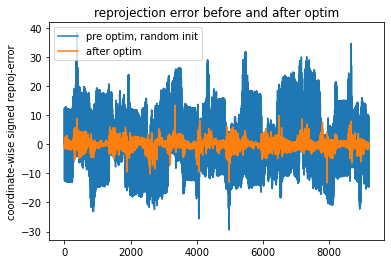

In [62]:
plt.plot(f0, label = 'pre optim, random init')
plt.plot(res.fun, label = 'after optim')
plt.legend()
plt.ylabel('coordinate-wise signed reproj-error')
plt.title('reprojection error before and after optim')
plt.savefig(os.path.join(plot_folder,'reproj-err-per-frame-initdlc3d.png'))

In [63]:
# now we first refill the full sized containers, then revert to dicts.

# do the pts_array_3d_clean
array_3d_back = refill_nan_array(points_3d, 
                               info_dict, 
                               dimension = '3d')
pose_dict_3d_refill = ordered_arr_3d_to_dict(array_3d_back, info_dict)

# pts_3d_BA
BA_array_3d_back = refill_nan_array(points_3d, 
                               info_dict, 
                               dimension = '3d')
BA_dict = ordered_arr_3d_to_dict(BA_array_3d_back, info_dict)

# pts_2d_orig
pts_array_2d_og = np.reshape(pts_array_2d, (pts_array_2d.shape[0] * pts_array_2d.shape[1], -1))
array_2d_orig = refill_nan_array(pts_array_2d_og, 
                              info_dict, 
                               dimension = '2d')
pose_list_2d_orig = arr_2d_to_list_of_dicts(array_2d_orig,
                                              info_dict)
                                              
# pts_2d_reproj
array_2d_reproj_back = refill_nan_array(points_proj, 
                              info_dict, 
                               dimension = '2d')
pose_list_2d_reproj = arr_2d_to_list_of_dicts(array_2d_reproj_back,
                                              info_dict)

In [64]:
joined_list_2d = pose_list_2d_orig + pose_list_2d_reproj
joined_list_3d = []
joined_list_3d.append(pose_dict_3d_refill)
joined_list_3d.append(BA_dict)

In [65]:
#Red = ground truth, blue = proj
color_list_2d = ['red', 'red', 'blue', 'blue']
color_list_3d = ['red', 'blue']
# set limits to be the maximum of the two plots
# we are padding the limits of the axis since some points lie at the border.
pad = 1
lims = {}
x_min = np.nanmin(BA_dict['x_coords'])
x_max = np.nanmax(BA_dict['x_coords'])
y_min = np.nanmin(BA_dict['y_coords'])
y_max = np.nanmax(BA_dict['y_coords'])
z_min = np.nanmin(BA_dict['z_coords'])
z_max = np.nanmax(BA_dict['z_coords'])
lims['x'] = [x_min, x_max]
lims['y'] = [y_min, y_max]
lims['z'] = [z_min, z_max]


In [66]:
scene_lims = [[x_min, x_max], [y_min, y_max], [z_min, z_max]]
print(scene_lims)

[[-0.18772737335673867, 0.4960386892784607], [-0.24932632026731785, 0.08523673517868362], [1.2734428179266468, 2.061550627710578]]


In [67]:
ind_start = 40
ind_end = 45 #80

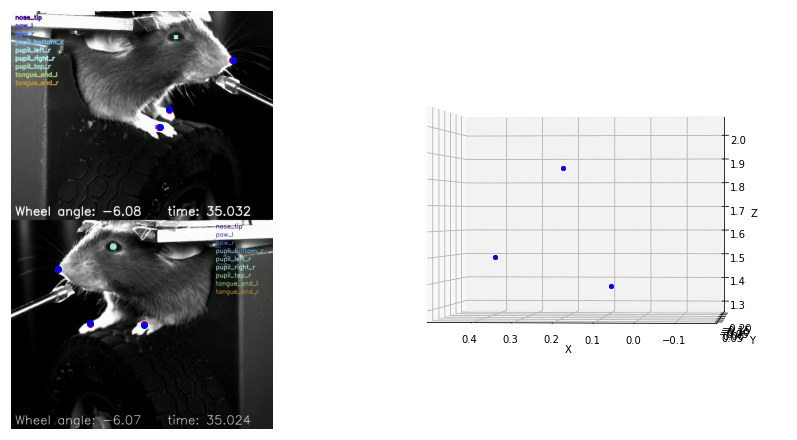

In [68]:
#### 3d plot
from matplotlib.gridspec import GridSpec
import mpl_toolkits.mplot3d.axes3d as p3
%matplotlib inline

fig = plt.figure(constrained_layout=True, figsize = (12,6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1], projection = '3d') # https://matplotlib.org/3.1.1/gallery/mplot3d/subplot3d.html
image_folder = 'images_test'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

ax2.view_init(elev=0, azim=90) # see https://stackoverflow.com/questions/12904912/how-to-set-camera-position-for-3d-plots-using-python-matplotlib

#FRONT RIGHT PAW
for i in range(ind_start,ind_end):
    # clear both ax1 and ax2
    ax1.cla()
    ax2.cla()   
    # load image
    img_1 = read_image(path_images[0][i], flip=False)
    img_2 = read_image(path_images[1][i], flip=False)
    img = np.concatenate((img_1, img_2), axis=0)
    plot_image_labels(img,\
                        joined_list_2d,
                        i,
                        color_list_2d,
                        ax = ax1, top_img_height=IMG_HEIGHT_1)
    
    ax2.azim += 1
    plot_3d_points(joined_list_3d,
                   lims,
                   i,
                   color_list_3d,
                   ax=ax2)
    im_int = str('%.5i' % i)
    plt.savefig(image_folder + '/' + 'im' + im_int + '.png')


In [69]:
write_video(image_dir='./images_test/', out_file='reconstruction.mp4')

# Plot Bundle Adjusted Through Time

In [70]:
plot_dir = Path('./3d_point_plots/')
plot_dir.mkdir(exist_ok=True, parents=True)
for i in range(ind_start, ind_end):
    slice_3d = np.asarray([BA_dict['x_coords'][i], BA_dict['y_coords'][i],BA_dict['z_coords'][i]]).transpose()
    fig = plot_cams_and_points(points_3d=slice_3d, scene_lims=None, point_size=5, scene_aspect='cube', show_plot=False, title="3D Points Through Time")
    fig.write_image(str(plot_dir / f"points_{i}.png"))

In [71]:
write_video(image_dir=plot_dir, out_file="points_through_time.mp4")

# Plot Skeleton

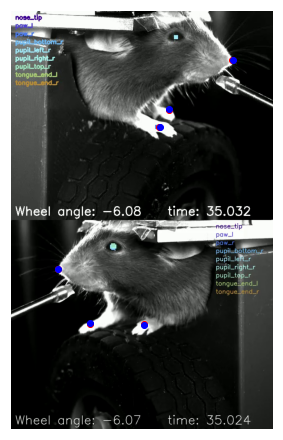

In [73]:
#### 3d plot
from matplotlib.gridspec import GridSpec

%matplotlib inline
plot_dir = Path('./3d_point_plots/')

fig = plt.figure(constrained_layout=True, figsize = (12,6))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


for i in range(ind_start,ind_end):
    # clear both ax1 and ax2
    ax1.cla()
    # load image
    img_1 = read_image(path_images[0][i], flip=False)
    img_2 = read_image(path_images[1][i], flip=False)
    img = np.concatenate((img_1, img_2), axis=0)

    plot_image_labels(img,\
                        joined_list_2d,
                        i,
                        color_list_2d,
                        ax = ax1, top_img_height=IMG_HEIGHT_1)

    im_int = str('%.5i' % i)
    plt.savefig(str(plot_dir / ('im' + im_int + '.png')),bbox_inches='tight', pad_inches=0)

In [74]:
#['nose', 'paw1LH', 'paw2LF', 'paw3RF', 'paw4RH', 'tailBase', 'tailMid']
#0: nose
#1: left front paw
#2: left back paw
#3: right back paw
#4: right front
#5: tail base
#6: tail mid

In [75]:
#Plot skeleton
from PIL import Image

for i in range(ind_start, ind_end):
    im_int = str('%.5i' % i)
    proj_im_path = plot_dir / f"im{im_int}.png"
    proj_img = Image.open(proj_im_path)
    width, height = proj_img.size

    slice_3d = np.asarray([BA_dict['x_coords'][i], BA_dict['y_coords'][i],BA_dict['z_coords'][i]]).transpose()
    
    #Add coordinates of each bodypart to dict
    skeleton_bp = {}
    skeleton_bp['nose'] = (BA_dict['x_coords'][i][2], BA_dict['y_coords'][i][2], BA_dict['z_coords'][i][2])
    skeleton_bp['paw1'] = (BA_dict['x_coords'][i][0], BA_dict['y_coords'][i][0], BA_dict['z_coords'][i][0])
    skeleton_bp['paw2'] = (BA_dict['x_coords'][i][1], BA_dict['y_coords'][i][1], BA_dict['z_coords'][i][1])

    #Now, define lines:
    #List of tuples indicating line from bodypart to bodypart, e.g. [('nose', 'tail_base')]
    #   draws a line from the nose to the base of the tail.
    #Also, to specify a midpoint, use a tuple in the tuple, e.g. [(('nose', 'tail_base'), 'paw_1')]
    #   draws a line from the midpoint of 'nose' and 'tail_base' to a paw.

    skeleton_lines = [('nose', 'paw1'), ('nose', 'paw2')]
    #For each paw

    #---------Plot 3D points with skeleton
    scene_camera = dict(
        up=dict(x=0, y=0, z=0),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=0, y=-2, z=-2.5)
    )
    

    fig = plot_cams_and_points(points_3d=slice_3d, point_size=5, scene_aspect='cube',  scene_lims=scene_lims,                                                      scene_camera=scene_camera, show_plot=False, title="3D Points Through Time", skeleton_bp=skeleton_bp,                                skeleton_lines=skeleton_lines)
    fig.update_layout(showlegend=False)

    fig.write_image(str(plot_dir / f"3dpoints_{i}.png"), width=width, height=height)

    #--------------Now repeat, but include cameras in plot


    fig = plot_cams_and_points(cam_group=cam_group, points_3d=slice_3d, point_size=5, scene_aspect='cube',                                                         scene_camera=scene_camera, show_plot=False, title="3D Points Through Time",                                                         skeleton_bp=skeleton_bp, skeleton_lines=skeleton_lines)

    fig.update_traces(textfont_size=1)
    fig.update_layout(showlegend=False)
    fig.write_image(str(plot_dir / f"3dpoints_cams_{i}.png"), width=width, height=height)



In [76]:
#Combine images
from pathlib import Path
from utils.utils_IO import read_image
import numpy as np
from PIL import Image

combined_dir = Path('./combined/')
combined_dir.mkdir(parents=True, exist_ok=True)
for i in range(ind_start,ind_end):
    im_int = str('%.5i' % i)
    proj_im_path = plot_dir / f"im{im_int}.png"
    proj_img = Image.open(proj_im_path)


    point_im_path = plot_dir / f"3dpoints_{i}.png"
    points_img = Image.open(point_im_path)

    cam_im_path = plot_dir / f"3dpoints_cams_{i}.png"
    cam_img = Image.open(cam_im_path)


    width, height = proj_img.size
    total_width = width * 3
    total_height = height

    new_im = Image.new('RGB', (total_width, total_height))

    x_offset = 0
    new_im.paste(proj_img, (0,0))
    new_im.paste(points_img, (width,0))
    new_im.paste(cam_img, (width * 2,0))

    new_im.save(str(combined_dir / f"combined_{i}.png"))

In [77]:
write_video(image_dir=combined_dir, out_file='combined.mp4')

# Epipolar Lines

In [78]:
from scipy.spatial.transform import Rotation as R
#Bundle adjustment code: https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html

# Get rotation vector
rot_vec_1 = R.from_rotvec(camera_1.get_rotation())
R1 = rot_vec_1.as_matrix()
print("R1: ", R1)
#Get translation vector
t1 = camera_1.get_translation()
print('t1: ', t1)

#Get intrinsic matrix
K1 = camera_1.get_camera_matrix()

# Get rotation vector
rot_vec_2 = R.from_rotvec(camera_2.get_rotation())
R2 = rot_vec_2.as_matrix()
print("R2: ", R2)
#Get translation vector
t2 = camera_2.get_translation()
print('t2: ', t2)

#Get intrinsic matrix
K2 = camera_2.get_camera_matrix()

# --- Now compute relevant quantities for F estimation ------
#Camera matrix basics: http://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
#Fundamental matrix computation: https://rb.gy/dd0nz2

#Compute projection matrices
P1 = np.matmul(K1, np.concatenate((R1, t1[:, np.newaxis]), axis=1))
P2 = np.matmul(K2, np.concatenate((R2, t2[:, np.newaxis]), axis=1))

#Get camera center (view 1)
R1_inv = np.linalg.inv(R1) 
C = np.matmul(-R1_inv, t1)
C = np.append(C, 1)

F = np.matmul(skew(np.matmul(P2, C)), np.matmul(P2, np.linalg.pinv(P1)))
print('F: ', F)

R1:  [[ 0.96867917  0.24819014 -0.00789378]
 [-0.24781776  0.96423626 -0.09399363]
 [-0.01571682  0.09300589  0.9955415 ]]
t1:  [ 0.05120742  0.22238785 -0.2502038 ]
R2:  [[-0.42828394 -0.1912172   0.8831811 ]
 [-0.10257753  0.98132515  0.16272307]
 [-0.89780328 -0.02090286 -0.43990039]]
t2:  [-1.54540916 -0.22447852  2.69221242]
F:  [[-5.01595368e-02 -3.52331415e+00  6.21491053e+02]
 [-3.18938394e+00 -1.46572109e-01  2.07546378e+03]
 [ 5.35087014e+02  1.11824675e+02 -3.62792153e+05]]


In [79]:
x_top = joined_list_2d[0]['x_coords'].ravel()[:,np.newaxis]
y_top = joined_list_2d[0]['y_coords'].ravel()[:,np.newaxis]

x_bot = joined_list_2d[1]['x_coords'].ravel()[:,np.newaxis]
y_bot = joined_list_2d[1]['y_coords'].ravel()[:,np.newaxis]

num_points = None
if num_points is not None:
    pts1 = np.concatenate((x_top, y_top), axis=-1)[:num_points, :]
    pts2 = np.concatenate((x_bot, y_bot), axis=-1)[:num_points, :]
else:
    pts1 = np.concatenate((x_top, y_top), axis=-1)
    pts2 = np.concatenate((x_bot, y_bot), axis=-1)

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

In [80]:
epipolar_folder = './epipolar_lines/'
if not os.path.exists(epipolar_folder):
    os.makedirs(epipolar_folder)

for i in range(len(path_images[0])//4):

    # load image
    top_img = (read_image(path_images[0][i], flip=False) * 255).astype(np.uint8)
    bottom_img = (read_image(path_images[1][i], flip=False) * 255).astype(np.uint8)

    #Recall, indices 0 and 2 correspond to bottom image
    x_t = joined_list_2d[0]['x_coords'][i][:,np.newaxis]
    y_t = joined_list_2d[0]['y_coords'][i][:,np.newaxis]

    x_b = joined_list_2d[1]['x_coords'][i][:,np.newaxis]
    y_b = joined_list_2d[1]['y_coords'][i][:,np.newaxis]

    points_top = np.concatenate((x_t,y_t), axis=1)
    points_bot = np.concatenate((x_b,y_b), axis=1)

    
    #Get rid of nans
    points_bot = points_bot.astype(np.int32)
    points_bot = points_bot[~np.isnan(points_bot).any(axis=1)]

    points_top = points_top.astype(np.int32)
    points_top = points_top[~np.isnan(points_top).any(axis=1)]

    top_img_with_points = draw_circles(top_img, points_top)
    bot_img_with_points = draw_circles(bottom_img, points_bot)
    #cv2.imwrite('epipolar_lines/top_image_points.jpg', top_img_with_points)
    #cv2.imwrite('epipolar_lines/bot_image_points.jpg', bot_img_with_points)

    #Homogenize points
    ones = np.ones(points_top.shape[0])[:,np.newaxis]
    points_top_homog = np.concatenate((points_top, ones), axis=-1)
    points_bot_homog = np.concatenate((points_bot, ones), axis=-1)
    
    aug_F = np.tile(F, (points_top_homog.shape[0], 1, 1))
    lines_bot = np.squeeze(np.matmul(aug_F, points_top_homog[:,:,np.newaxis]))
    #This^ gives us lines as vectors [a,b,c] --> ax + by + c = 0

    for line_vec in lines_bot:
        #Get x and y intercepts (on image) to plot
        #y = 0: x = -c/a
        x_intercept = int(-line_vec[2] / line_vec[0])
        #x = 0: y = -c/b
        y_intercept = int(-line_vec[2] / line_vec[1])
        bottom_img = drawLine(bottom_img, x_intercept, 0, 0, y_intercept)
        #bottom_img = cv2.line(bottom_img, (x_intercept, 0), (0, y_intercept), (255, 255, 255), thickness=1)

    final_img = cv2.vconcat([top_img, bottom_img])
    cv2.imwrite(f'epipolar_lines/{i}.jpg', final_img)

In [81]:
write_video(image_dir=epipolar_folder, out_file="epipolar_video.mp4")

# Undistorting